# EEG analysis in MNE Python

written by Carina Forster
forster@cbs.mpg.de

last updated 24.06.2024

Historically, MNE was a software for computing cortically constrained Minimum Norm Estimates from MEG and EEG data. The historical core functions of MNE were written by Matti Hämäläinen in Boston and originate in part from the Elekta software that is shipped with its MEG systems. The FIFF is Elektas Functional Imaging File Format that goes along with .fif file extensions and is natively used by its MEG systems. For these reasons the MNE software is internally relying on the FIFF files. 

Today the situation is a bit different though. MNE is nowadays developed mostly in Python by an international team of researchers from diverse laboratories and has widened its scope.

MNE supports advanced sensor space analyses for EEG, temporal ICA, many different file formats and many other inverse solvers, for example beamformers. 

Some of our contributors even use it for intracranial data. If you want, MNE can be thought of as MEG’n’EEG.

If not installed install mne with pip and a magic command

Otherwise, we start by importing mne 

In [1]:
import mne
import numpy as np
import os

In [2]:
mne.__version__

'1.7.1'

In [3]:
# this command enables matplotlib to use the qt backend that allows you to view data interactively
#%matplotlib inline
%matplotlib qt

## Loading data

In [7]:
# We load data for a single participant from the mne samples
#loading data in mne depends on the hardware you used for recording the data and the file format

In [4]:
sample_data_folder = mne.datasets.sample.data_path()
sample_data_raw_file = os.path.join(sample_data_folder, 'MEG', 'sample',
                                    'sample_audvis_filt-0-40_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, preload=True)

Opening raw data file C:\Users\Carina\mne_data\MNE-sample-data\MEG\sample\sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


In [5]:
# View dataset info
raw.info

Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus, 59 EEG, 1 EOG"
Bad channels,"MEG 2443, EEG 053"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,150.15 Hz
Highpass,0.10 Hz
Lowpass,40.00 Hz


In [6]:
# Select only EEG channels 
raw_eeg = raw.copy().pick_types(meg = False, eeg = True, eog = True)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


## Raw signal
We can now plot and look at the raw signal. We can already identify some artifacts in there - we will deal with them at the next step.

MNE offers a pretty GUI (graphical user interface) to view rate data but the setup depends on your system and might take some time: 

for setting up the GUI please check the mne page:

https://mne.tools/dev/install/advanced.html

Using matplotlib as 2D backend.


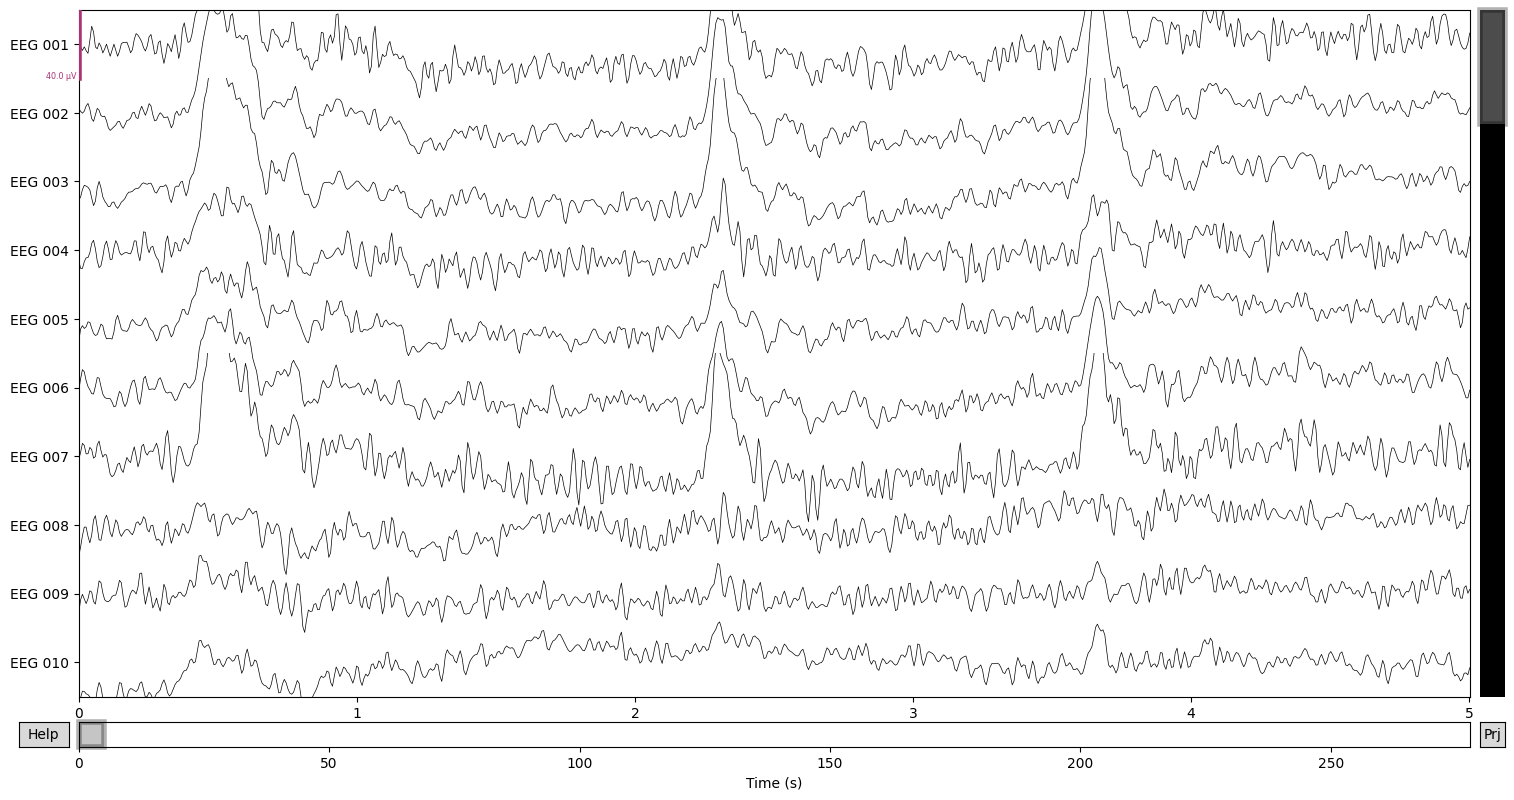

Channels marked as bad:
['EEG 002']


In [7]:
raw_eeg.plot(duration=5, n_channels=10)

Let's check the actual data structure

In [ ]:
data = raw_eeg.get_data()
data.shape

(60, 41700)

Our original data is in the shape channels x timepoints

the length of the timepoints depends on the sampling frequency (how many times per second do you measure the electrical signal)
and the actual length of the measurement, e.g.

250 Hz sampling frequency * 5 minutes of measurement = 250*60*5 = 7500

How long is the measurement time in the dataset we loaded?

Whabt about the channels?

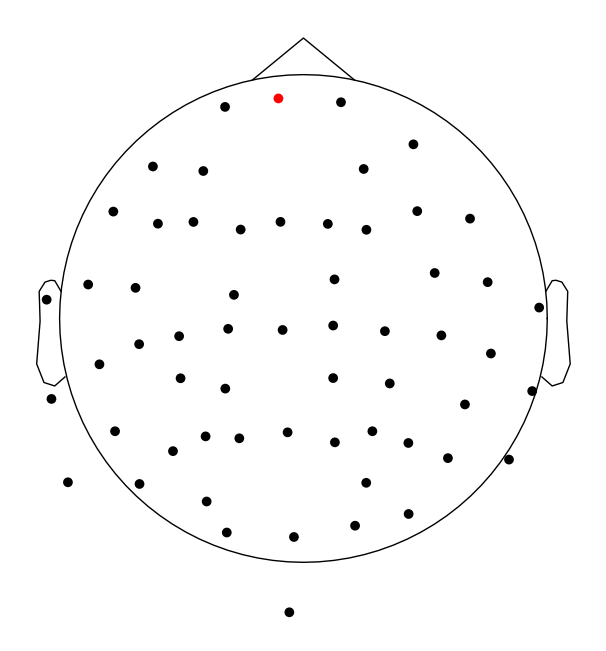

In [8]:
raw_eeg.plot_sensors()

## Preprocessing
### Filtering
Filtering is an important step in EEG analysis - the sensors pick up anything from very slow (<1 Hz) to extremely fast (>200 Hz) oscillations. Not all of these are likely to be related to brain activity. Typically, the data is filtered between 1 and 20-50 Hz to get a relevant range.

We filter the data in this range because we are not interested in very low and very high frequencies as they are most likely muscle or measurement artifacts.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 497 samples (3.310 s)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 13.639 (s)
Plotting power spectral density (dB=True).


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
C:\Users\Carina\AppData\Local\Temp\ipykernel_17080\4024856461.py:2: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  raw_eeg.plot_psd()


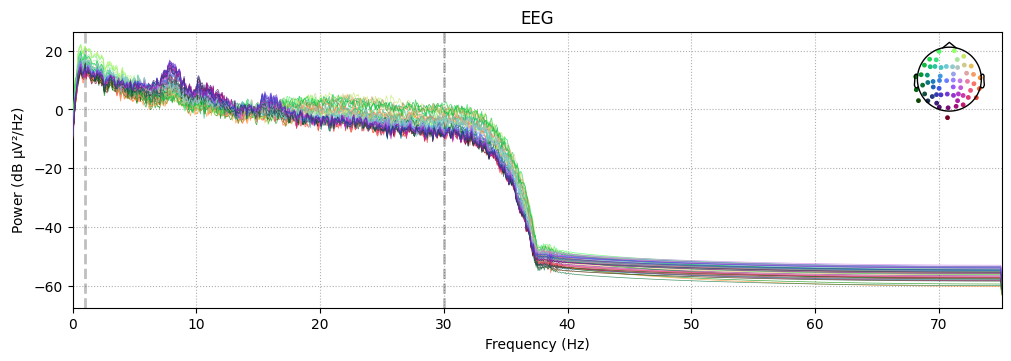

In [9]:
raw_eeg.filter(1,30)
raw_eeg.plot_psd()

### Independent component analysis (ICA)

ICA is one of the methods used to remove artifacts in the data (such as blinks, heartbeats and so on). Briefly, your EEG signal is a mixture of many signals (brain activity, muscle activity and so on) and ICA helps "unmix" or separate them.

We will fit the ICA algorithm, plot the components and then remove those that look like artifacts. The details are beyond the scope of the class, but more information can be found here: https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html

In [10]:
# set up and fit the ICA
ica = mne.preprocessing.ICA(n_components=20, random_state = 123, max_iter=800)
ica.fit(raw_eeg)

Fitting ICA to data using 58 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 1.8s.


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,53 iterations on raw data (41700 samples)
ICA components,20
Available PCA components,58
Channel types,eeg
ICA components marked for exclusion,—


Here are the components in the data. 

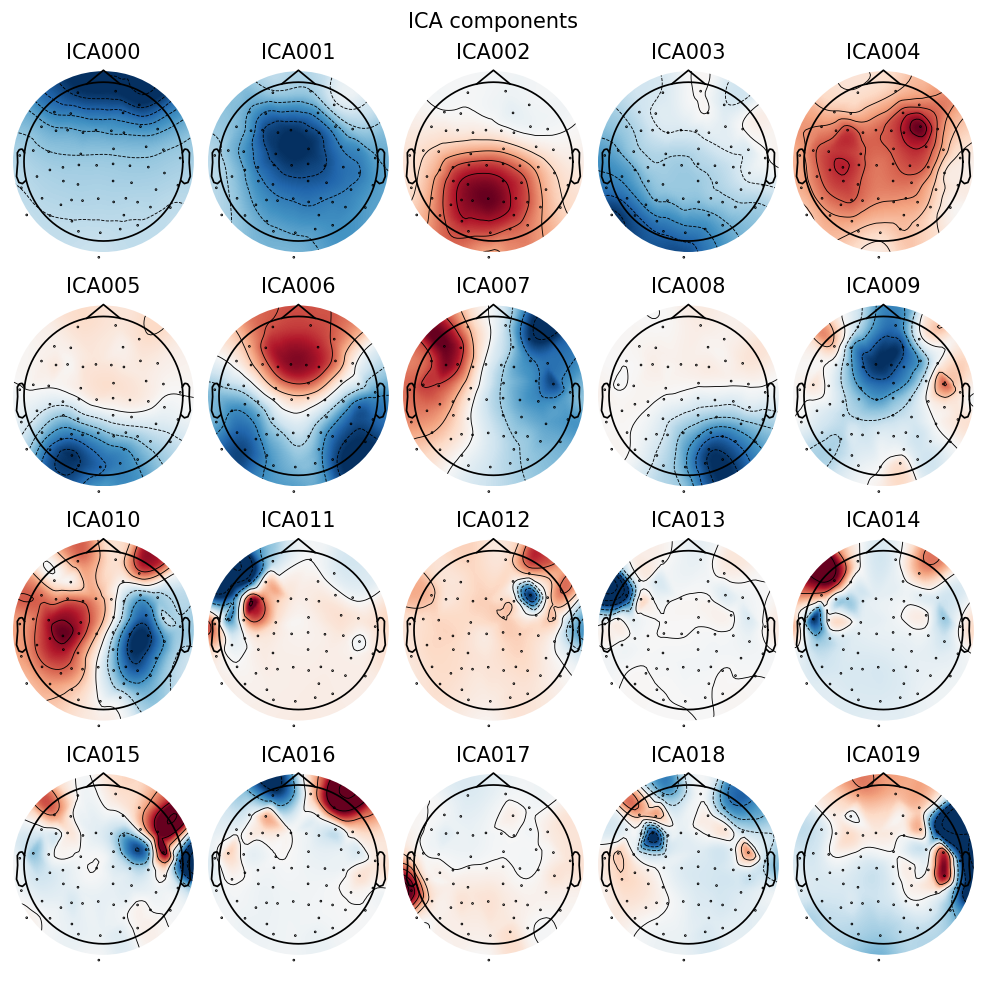

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items activated
    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
138 matching events found
No baseline correction applied
0 projection items ac

In [ ]:
ica.plot_components(inst=raw_eeg)

if you pass an instance (raw data or epoched data) you can view the ICA components interactively

We can visualize the effects of excluding a particular component from the data.

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component


    Projecting back using 58 PCA components


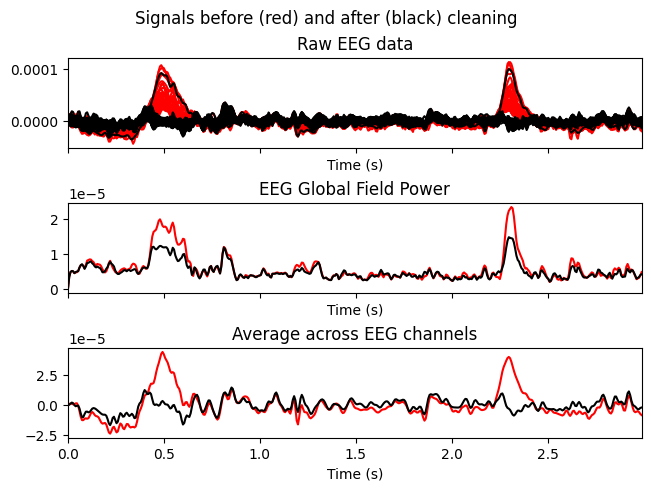

In [12]:
ica.plot_overlay(raw_eeg, exclude=[0], picks='eeg')

Then, we can exclude these components from the data.

In [13]:
ica.exclude = [0]
raw_eeg_ica = raw_eeg.copy()
ica.apply(raw_eeg_ica);

Applying ICA to Raw instance


    Transforming to ICA space (20 components)
    Zeroing out 1 ICA component
    Projecting back using 58 PCA components


Nice! We got rid of blinks and high and low frequency noise! With your own data you might want to spend more time on preprocessing. This is an important step! 

### Epoching = cropping the data of interest (usually around a stimulus or response)

During a EEG or MEG measurement you send triggers to the EEG software. This allows you later to know at what time the events of interest in your study occured. For example, my paradigm uses somatosensory stimulation, so I placed a trigger at the timepoint of stimulation. 
This allows me to later analyze the Somatosensory Evoked Potential (SEP). 

In [14]:
events = mne.find_events(raw, stim_channel='STI 014')

319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]


In [15]:
print(events[:5]) #timesample, duration, trigger label

[[6994    0    2]
 [7086    0    3]
 [7192    0    1]
 [7304    0    4]
 [7413    0    2]]


What are the events in our dataset?

In [16]:
event_dict = {'auditory/left': 1, 'auditory/right': 2, 'visual/left': 3,
              'visual/right': 4, 'smiley': 5, 'buttonpress': 32}

In [17]:
fig = mne.viz.plot_events(events, event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw_eeg_ica.first_samp)

Always check your triggers in a EEG study. If your triggers are missing or 
at the wrong timepoint you can throw away your data!

Let's finally epoch our data

In [18]:
epochs = mne.Epochs(raw_eeg_ica, events, event_id=event_dict, tmin=-0.2, tmax=0.5)

Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated


Using data from preloaded Raw for 319 events and 106 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 20 events and 106 original time points ...


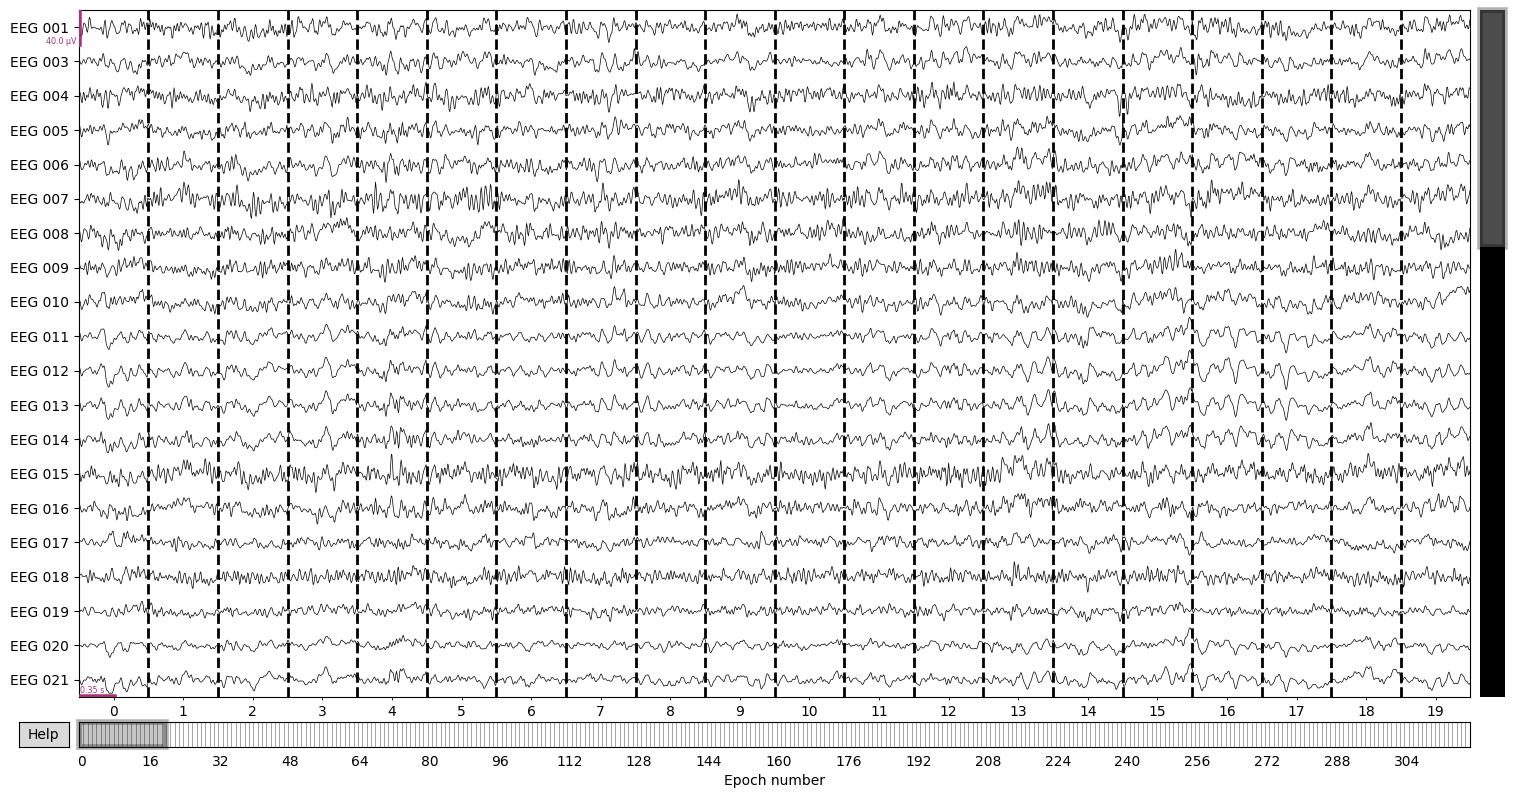

Dropped 1 epoch: 9
The following epochs were marked as bad and are dropped:
[9]
Channels marked as bad:
['EEG 002']


In [19]:
epochs.plot()

Like Raw objects, Epochs objects also have a number of built-in plotting methods. One is plot_image, which shows each epoch as one row of an image map, with color representing signal magnitude; the average evoked response and the sensor location are shown below the image.

Now we want to finally do some science. Is there a difference between our conditions?

In [21]:
conds_we_care_about = ['auditory/left', 'auditory/right',
                       'visual/left', 'visual/right']
epochs.equalize_event_counts(conds_we_care_about)
# this operates in-place, meaning you don't have to declare it to a variable to save the outcome

aud_epochs = epochs['auditory']
vis_epochs = epochs['visual']

Dropped 7 epochs: 0, 13, 15, 17, 34, 100, 231


In [22]:
aud_epochs.get_data().shape
#vis_epochs.get_data().shape

Using data from preloaded Raw for 140 events and 106 original time points ...


(140, 60, 106)

In [23]:
epochs.plot_image()

Using data from preloaded Raw for 311 events and 106 original time points ...
Not setting metadata
311 matching events found
No baseline correction applied
0 projection items activated
combining channels using GFP (eeg channels)


[<Figure size 640x480 with 3 Axes>]

Epochs have the format: number of epochsxchannelsxtimepoints

## ERP = Event related potential

Evoked = average over all epochs

In [24]:
aud_evoked = aud_epochs.average()
vis_evoked = vis_epochs.average()

mne.viz.plot_compare_evokeds(dict(auditory=aud_evoked, visual=vis_evoked),
                             legend='upper left', show_sensors='upper right')

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


[<Figure size 800x600 with 2 Axes>]

Projections have already been applied. Setting proj attribute to True.


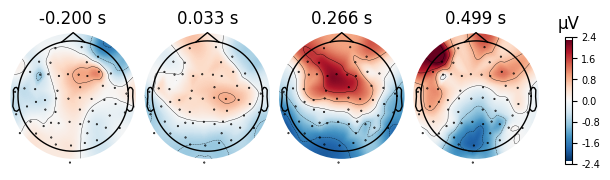

In [25]:
aud_evoked.plot_joint()
aud_evoked.plot_topomap()

In [26]:
mne.viz.plot_compare_evokeds(dict(auditory=aud_evoked, visual=vis_evoked),
                             legend='upper left', show_sensors='upper right', picks = 'EEG 020')

[<Figure size 800x600 with 2 Axes>]

Where is the strongest difference between conditions? (in our case in which channel)

In [27]:
evoked_diff = mne.combine_evoked([aud_evoked, vis_evoked], weights=[1, -1]).plot_topo(color='b', legend=True)

How do we test for a statistical significance between conditions in an ERP?

https://mne.tools/stable/auto_tutorials/stats-sensor-space/10_background_stats.html#sphx-glr-auto-tutorials-stats-sensor-space-10-background-stats-py